# Cube Reprojection and Signal Masking Tutorial, version 4

### Author: Alyssa Bulatek (https://github.com/abulatek)

#### Last updated: May 9, 2022

Adapted from a previous tutorial on the same subject by Adam Ginsburg, Eric Koch, Tom Robitaille, and Erik Rosolowsky. This tutorial shows how to take two spectral cubes observed toward the same part of the sky, but at different frequencies, and put them onto the same grid. Then, we use one spectral cube to mask the other, which is helpful for situations where the velocity structure of one cube is more complicated than the other.

## Index 

 * [Step 0: Some imports and version checks](#Step-0:-Some-imports-and-version-checks)
 * [Step 1: Download](#Step-1:-Download-the-data)
 * [Step 2: Open files, collect metadata](#Step-2:-Load-the-cubes)
 * [Step 3: Convert to velocity](#Step-3:-Convert-cubes-from-frequency-to-velocity)
 * [Step 4: Spectral Interpolation](#Step-4:-Spectral-Interpolation)
 * [Step 5: Spatial Smoothing and Reprojection](#Step-5:-Spatial-Smoothing-and-Reprojection)
 * [Step 6: Signal Masking](#Step-6:-Signal-Masking)
 * [Step 7: Moment Maps](#Step-7:-Moment-Maps)
 * [Step 8: Masking Outliers](#Step-8.-Masking-Outliers)
 
***NB:*** *In this example, we do spectral smoothing and interpolation (step 4) before spatial smoothing and interpolation (step 5), but if you have a varying-resolution cube (with a different beam size for each channel), you have to do spatial smoothing first. This is because smoothing two spectral channels together that have different beamsizes will blend unrelated objects on the sky.*

## Step 0: Some imports and version checks

In [1]:
import matplotlib.pyplot as plt
# # Make plots have dark backgrounds; run this if your notebook is in dark mode
# plt.style.use('dark_background')

# Make sure spectral_cube is up-to-date
from spectral_cube import SpectralCube
import spectral_cube
print(f'spectral_cube version: {spectral_cube.__version__}')
print(f'path to spectral_cube installation: {spectral_cube.__path__}')

# Make sure astropy and reproject are somewhat up-to-date
# Used to require development version of astropy; 4.3.dev1788+ga3263b6 worked for me, but now so does 4.3.1
import astropy
import reproject
print(f'astropy version: {astropy.__version__}')
print(f'reproject version: {reproject.__version__}')

spectral_cube version: 0.6.1.dev153+g7d0b9c7
path to spectral_cube installation: ['/blue/adamginsburg/abulatek/spectral-cube/spectral_cube']
astropy version: 4.3.1
reproject version: 0.8.dev31+g9f8ec7b


## Step 1: Download the data

The first step is to pick out and download the cubes you will use for the reprojection. Here, we choose to download two cubes from the [ALMA Archive](https://almascience.nrao.edu/aq/), which is a publicly-available database where data taken by ALMA are stored after they exit their proprietary period. If you already have the cubes you will use for this tutorial locally, you can skip this step.

The two cubes we download here both cover the same field at different wavelengths: a water maser in the Galactic Center molecular cloud G0.253+0.016, also known as "The Brick." `filename_1` points to a cube containing the H2CS 4(1,3)-3(1,2) line (139.483699 GHz), and `filename_2` points to a cube containing the SiO v=5-4 line (217.104984 GHz).

In [2]:
import numpy as np
from astropy.utils.data import download_file

In [3]:
filename_1 = download_file("https://almascience.nrao.edu/dataPortal/member.uid___A001_X1465_X3a33.BrickMaser_sci.spw71.cube.I.manual.image.pbcor.fits",
                           cache=True)
filename_1

'/home/abulatek/.astropy/cache/download/url/33718a6f64d8a437fe89bff80278ca22/contents'

In [4]:
filename_2 = download_file("https://almascience.nrao.edu/dataPortal/member.uid___A001_X87d_X141.a_sma1_sci.spw27.cube.I.pbcor.fits",
                          cache=True)
filename_2

'/home/abulatek/.astropy/cache/download/url/391fb3a562ec7b94842f7b6e2a55c67e/contents'

## Step 2: Load the cubes

Now, we will load the cubes into memory using the package `spectral_cube`, which we imported in Step 0. As previously mentioned, the two cubes are at different frequencies (139 GHz and 217 GHz). Once we've loaded the cubes in, we'll use the method `find_lines` to confirm the presence of the line we expect to find in each of the cubes (H2CS in `cube1`, SiO in `cube2`).

In [5]:
cube1 = SpectralCube.read(filename_1)
cube1

SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: FREQ      unit_s: Hz     range: 139434992275.503 Hz:139503942362.300 Hz

In [6]:
cube2 = SpectralCube.read(filename_2)
cube2

SpectralCube with shape=(478, 420, 420) and unit=Jy / beam:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:    478  type_s: FREQ      unit_s: Hz     range: 216957714464.027 Hz:217190639088.700 Hz

In [7]:
cube1.find_lines(chemical_name=' H2CS ').show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Linelist
0,H2CS,Thioformaldehyde,--,--,139.48341,0.00028,"4(1,3)-3(1,2)",-3.2185,30.51674,11.223,-4.44732,0.17,16.1465,23.23108,20.79917,29.92519,JPL
1,H2CS,Thioformaldehyde,--,--,139.4836816,5e-05,"4(1,3)-3(1,2)",-3.2182,30.59661,11.251,-4.44619,--,16.1329,23.21151,20.78557,29.90563,CDMS
2,H2CS,Thioformaldehyde,139.483699,1.7e-05,139.483741,2.4e-05,"4(1,3)-3(1,2)",0.0,30.59472,3.75,-3.94426,0.17,16.133,23.21165,20.78568,29.90578,SLAIM
3,H2CS,Thioformaldehyde,139.483699,1.7e-05,--,--,"4(1,3)-3(1,2)",0.0,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,Lovas


In [8]:
cube2.find_lines(chemical_name='SiO').show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Linelist
0,"SiO,v=0-10",Silicon monoxide (global fit),--,--,217.104919,2e-06,"J=5-4,v=0-0",-1.3211,47.9909,0.0,-3.28429,--,14.4843,20.83981,21.72614,31.25927,CDMS
1,SiOv=0,Silicon Monoxide,--,--,217.10498,8e-05,5-4,-1.3211,47.99147,5.0,-3.28429,1.6,14.4843,20.83956,21.72614,31.25889,CDMS
2,SiOv=0,Silicon Monoxide,--,--,217.10498,5e-05,5-4,-1.3199,47.9911,5.0,-3.28429,1.6,14.4843,20.83956,21.72614,31.25889,CDMS
3,SiOv=0,Silicon Monoxide,--,--,217.10498,8e-05,5-4,-1.3166,48.14651,5.0,-3.28288,1.6,14.4843,20.83956,21.72614,31.25889,JPL
4,SiOv=0,Silicon Monoxide,217.104984,1.4e-05,--,--,5-4,0.0,0.0,0.0,0.0,1.6,0.0,0.0,0.0,0.0,Lovas
5,SiOv=0,Silicon Monoxide,217.104984,1.4e-05,217.10498,0.0001,5-4,0.0,47.6849,5.0,-3.28706,--,14.484,20.83913,21.72584,31.25846,SLAIM


We can see four listings for the H2CS 4(1,3)-3(1,2) line (139.483699 GHz) in `cube1`, each from different linelists. We can also see a few different SiO v=5-4 lines (217.104984 GHz), some from the same linelist (CDMS) and some from the other linelists. These printouts are just for verification purposes; we'll use the center frequencies we have written down in Step 1 for each of these transitions instead of the frequencies given in the `find_lines` function.

### Convert from Jy/beam to kelvin

At this point, we'll convert the cubes to be in units of kelvin instead of Jy/beam. This is because we'll be smoothing the cubes spatially in a future step, and the data values will only be preserved if the cubes are in units of kelvin instead of Jy/beam (since the latter units are dependent on the beamsize).

In [9]:
from astropy import units as u
cube1 = cube1.to(u.K)
cube2 = cube2.to(u.K)

## Step 3: Convert cubes from frequency to velocity

Now, we will convert these cubes from frequency units to velocity units using the rest frequencies of the transitions of interest. This is the first step to getting the cubes on a commmon velocity grid: we match up their rest frequencies at 0 km/s. We convert these cubes from frequency to velocity using the method `with_spectral_unit`, the documentation for which is available [here](https://spectral-cube.readthedocs.io/en/latest/api/spectral_cube.SpectralCube.html#spectral_cube.SpectralCube.with_spectral_unit) in the `spectral_cube` API.

In [10]:
cube1vel = cube1.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=139.483699*u.GHz)
cube1vel

SpectralCube with shape=(75, 250, 250) and unit=K:
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

In [11]:
cube2vel = cube2.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=217.104984*u.GHz)
cube2vel

SpectralCube with shape=(478, 420, 420) and unit=K:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:    478  type_s: VRAD      unit_s: km / s  range:     -118.278 km / s:     203.359 km / s

From the shape of the cube, we can see the H2CS cube is narrower in velocity, so we'll use that as the target spectral reprojection (otherwise, we would have empty velocity channels on either side of the smaller cube that would be getting reprojected).  However, the SiO cube is the smaller footprint on the sky.

### Do some quicklooks of the peak intensity to see what we expect to see

The cubes we are working with are three-dimensional: they have two spatial axes (on the plane of the sky) and one spectral axis. It is hard to visualize them in 3D easily, so we can collapse them into two dimensions in a variety of different ways. Here, we will collapse them along their spectral axis (`axis = 0`; `spectral_cube` usually makes the spectral axis the first axis as a default). In particular, for any given spatial coordinate in our cube, we will take the value of the brightest pixel along the spectral axis (the **peak flux density**). This summary image shows us where the bright emission is (spatially) in the cube, and how bright the emission in a certain region is in relation to the brightness of the emission in another region.

/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/spectral_cube.py:441: RuntimeWarning: All-NaN slice encountered
  **kwargs)


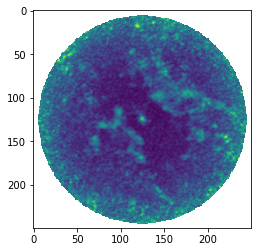

In [12]:
peak_fluxdensity1 = cube1.max(axis = 0)
peak_fluxdensity1.quicklook()

/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/spectral_cube.py:441: RuntimeWarning: All-NaN slice encountered
  **kwargs)


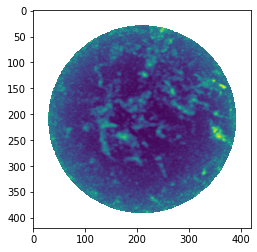

In [13]:
peak_fluxdensity2 = cube2.max(axis = 0)
peak_fluxdensity2.quicklook()

## Step 4: Spectral Interpolation

We can safely assume that any two cubes from ALMA are not perfectly matched on a spatial and spectral grid. One cube will have a higher spatial resolution than the other, and one cube will have a finer spectral resolution than the other. We must match these two cubes in two different steps: matching them on a spatial grid (2D), and matching them along their spectral axes (1D). We can treat these as roughly independent steps, and could do either first. *However, if your cubes have a varying spatial resolution (different beam size at each spectral channel), you will need to perform spatial smoothing first—you don't want to blend unrelated components of your source by smoothing spectrally before all channels are smoothed to the same spatial resolution.* Because each of our cubes have a constant spatial resolution, we will perform spectral smoothing first.

We need to match the spectral resolution of both cubes to each other. We'll start by printing out the spectral resolutions of both cubes.

In [14]:
velocity_res_1 = np.diff(cube1vel.spectral_axis)[0]
velocity_res_2 = np.diff(cube2vel.spectral_axis)[0]
velocity_res_1, velocity_res_2

(<Quantity 2.00262828 km / s>, <Quantity 0.67429189 km / s>)

`cube1`, our H2CS cube, has broader channels.  We want to smooth `cube2` to that channel width before doing the spatial reprojection. To do this, we'll smooth the spectral axis of `cube2` using a Gaussian with an appropriate FWHM:

In [15]:
fwhm_gaussian = (velocity_res_1**2 - velocity_res_2**2)**0.5
fwhm_gaussian

<Quantity 1.88569628 km / s>

Here is the [page on smoothing](https://spectral-cube.readthedocs.io/en/latest/smoothing.html#spectral-smoothing) in the `spectral_cube` documentation. Importantly, here, we're using a Gaussian to smooth the spectral channels, and then we say that the spectral resolution of the resulting cubes is equal to the FWHM of that Gaussian. However, spectral resolution is defined differently by the ALMA correlator: Adam thinks it's half of the channel width smoothed by a Hanning function and then sampled by the channel width, but the answer lies somewhere in the ALMA documentation. *The takeaway: we are not necessarily using the "correct" definition of resolution, but we could figure out what that is, if we wanted to.*

In [16]:
from astropy.convolution import Gaussian1DKernel
fwhm_to_sigma = np.sqrt(8*np.log(2))
# We want the kernel in pixel units, so we force to km/s and take the value
spectral_smoothing_kernel = Gaussian1DKernel(stddev = fwhm_gaussian.to(u.km/u.s).value / fwhm_to_sigma)

Then, let's cut down to the same spectral coverage. This is not technically necessary to do, but it is more computationally efficient to smooth over a smaller spectral range. We will do this in a general way, determining the smallest coverage and cutting both cubes based on those values, so no matter which cube has a larger spectral coverage, this code should work.

In [17]:
print(cube1vel.spectral_extrema)
print(cube2vel.spectral_extrema)

lower_limit = np.max([cube1vel.spectral_extrema[0].value, cube2vel.spectral_extrema[0].value])*(cube1vel.spectral_axis.unit)
upper_limit = np.min([cube1vel.spectral_extrema[1].value, cube2vel.spectral_extrema[1].value])*(cube1vel.spectral_axis.unit)

print(lower_limit)
print(upper_limit)

cube1vel_cutout = cube1vel.spectral_slab(lower_limit, upper_limit)
cube2vel_cutout = cube2vel.spectral_slab(lower_limit, upper_limit)
cube1vel_cutout, cube2vel_cutout

[-43.50907945 104.68541315] km / s
[-118.27802894  203.35920145] km / s
-43.509079452344274 km / s
104.68541315391005 km / s


(SpectralCube with shape=(75, 250, 250) and unit=K:
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s,
 SpectralCube with shape=(221, 420, 420) and unit=K:
  n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
  n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
  n_s:    221  type_s: VRAD      unit_s: km / s  range:      -43.432 km / s:     104.913 km / s)

We then smooth with the kernel. Note that this is doing 420x420 = 176400 smoothing operations on a length-221 spectrum: **it will take several minutes to run.**

In [18]:
cube2vel_smooth = cube2vel_cutout.spectral_smooth(spectral_smoothing_kernel)

Now that we've done spectral smoothing, we can resample the spectrum. We include the parameter `suppress_smooth_warning = True` in this step, because otherwise we'll see a warning that "the data should be smoothed prior to resampling." Since we have already smoothed the data, this warning can be safely ignored.

In [19]:
cube2vel_spectralresample = cube2vel_smooth.spectral_interpolate(cube1vel_cutout.spectral_axis, suppress_smooth_warning = True)
cube2vel_spectralresample

SpectralCube with shape=(75, 420, 420) and unit=K:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

## Step 5: Spatial Smoothing and Reprojection

Recall that our two cubes started with different beam sizes. Our goal is to match the beam sizes of the two cubes, and then to reproject the cubes onto the same spatial pixel grid. We can start to do this by printing out the beam sizes of the two cubes as they currently stand.

In [20]:
cube1vel_cutout.beam, cube2vel_spectralresample.beam

(Beam: BMAJ=1.29719604986604 arcsec BMIN=1.04247149438736 arcsec BPA=82.95313553702 deg,
 Beam: BMAJ=0.8935712308515601 arcsec BMIN=0.6649610689789199 arcsec BPA=85.81119797802 deg)

`cube1` again has the larger beam, so we'll smooth `cube2` to its resolution.

### Aside: mixed beams 

If cube1 and cube2 had different sized beams, but neither was clearly larger, we would have to convolve _both_ to a [common beam](https://radio-beam.readthedocs.io/en/latest/commonbeam.html#finding-the-smallest-common-beam). In this case, it's redundant and we could have just used cube1's beam, but this is the more general approach:

In [21]:
import radio_beam
common_beam = cube1vel_cutout.beam.commonbeam_with(cube2vel_spectralresample.beam)
common_beam

Beam: BMAJ=1.29719604986604 arcsec BMIN=1.04247149438736 arcsec BPA=82.95313553702 deg

In [22]:
# # This commented-out approach works in older versions of radio-beam:
# import radio_beam
# common_beam = radio_beam.commonbeam.common_2beams(radio_beam.Beams(beams=[cube1vel_cutout.beam, cube2vel_spectralresample.beam]))
# common_beam

In [23]:
cube2vel_spatialspectralsmooth = cube2vel_spectralresample.convolve_to(common_beam)
cube2vel_spatialspectralsmooth

SpectralCube with shape=(75, 420, 420) and unit=K:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

Now, we can reproject `cube2` onto the same spatial grid as `cube1`.

In [24]:
cube2vel_reproj = cube2vel_spatialspectralsmooth.reproject(cube1vel_cutout.header)
cube2vel_reproj 

SpectralCube with shape=(75, 250, 250) and unit=K:
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

These two cubes are now on an identical grid, and can be directly compared:

In [25]:
cube2vel_reproj, cube1vel_cutout

(SpectralCube with shape=(75, 250, 250) and unit=K:
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s,
 SpectralCube with shape=(75, 250, 250) and unit=K:
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s)

These spectra can now be overplotted as they are in the same unit with the same beam. Using the quicklook maps of the peak intensity from step 2, we know that there is some signal in the central region of our pointing, so we can plot the spectrum for the pixel there. We can approximate the pixel coordinate using the peak intensity map with fewer pixels, since we know both cubes got smoothed to that (coarser) spatial resolution. The center is at about (125, 125).

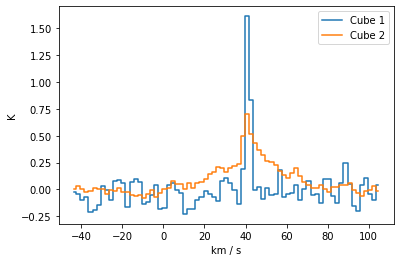

In [26]:
plt.plot(cube1vel_cutout[:,125,125].spectral_axis, cube1vel_cutout[:,125,125], linestyle = '-', drawstyle = 'steps-mid', label = 'Cube 1')
plt.plot(cube2vel_reproj[:,125,125].spectral_axis, cube2vel_reproj[:,125,125], linestyle = '-', drawstyle = 'steps-mid', label = 'Cube 2')
plt.xlabel(cube1vel_cutout.spectral_axis.unit)
plt.ylabel(cube1vel_cutout.unit)
plt.legend()
plt.show()

### Do a quick continuum subtraction

If we looked at the spectra we calculated in the previous step and saw that the baseline level of the spectra were not at zero, we would want to perform continuum subtraction to subtract off that non-zero baseline (since we're only working with the spectral lines for our purposes). Though our above spectra look like they are likely already continuum-subtracted, we can perform the following steps anyway. First, we'll calculate the median values of each of the cubes along the spectral axes. This gives us the approximate continuum value in each pixel. The median is more resistant to the presence of the spectral lines than the mean would be.

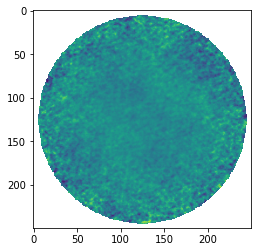

In [27]:
# Calculate the median value along the spectral axis
med1 = cube1vel_cutout.median(axis=0)
med1.quicklook()

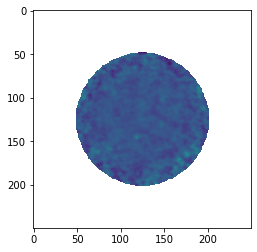

In [28]:
# Calculate the median value along the spectral axis
med2 = cube2vel_reproj.median(axis=0)
med2.quicklook()

In [29]:
# Perform background subtraction on cubes by subtracting the median spectral value for each pixel
cube1vel_cutout_bgsubtract = cube1vel_cutout - med1
cube2vel_reproj_bgsubtract = cube2vel_reproj - med2

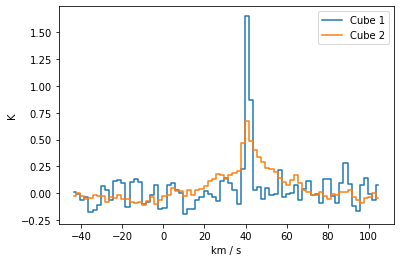

In [30]:
# Plot continuum-subtracted spectra for the central pixel
plt.plot(cube1vel_cutout_bgsubtract[:,125,125].spectral_axis, cube1vel_cutout_bgsubtract[:,125,125], linestyle = '-', drawstyle = 'steps-mid', label = 'Cube 1')
plt.plot(cube2vel_reproj_bgsubtract[:,125,125].spectral_axis, cube2vel_reproj_bgsubtract[:,125,125], linestyle = '-', drawstyle = 'steps-mid', label = 'Cube 2')
plt.xlabel(cube1vel_cutout.spectral_axis.unit)
plt.ylabel(cube1vel_cutout.unit)
plt.legend()
plt.show()

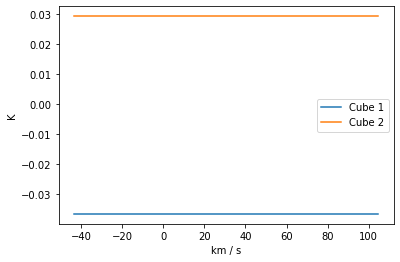

In [31]:
# Plot difference between non-cont-sub and cont-sub spectra for the central pixel
diff1 = cube1vel_cutout[:,125,125] - cube1vel_cutout_bgsubtract[:,125,125]
diff2 = cube2vel_reproj[:,125,125] - cube2vel_reproj_bgsubtract[:,125,125]

plt.plot(cube1vel_cutout_bgsubtract[:,125,125].spectral_axis, diff1, linestyle = '-', drawstyle = 'steps-mid', label = 'Cube 1')
plt.plot(cube2vel_reproj_bgsubtract[:,125,125].spectral_axis, diff2, linestyle = '-', drawstyle = 'steps-mid', label = 'Cube 2')
plt.xlabel(cube1vel_cutout.spectral_axis.unit)
plt.ylabel(cube1vel_cutout.unit)
plt.legend()
plt.show()

For our spectra, since they are already continuum-subtracted, there is almost no visible change.

## Step 6: Signal Masking

Now, we will use one of the molecules, H2CS, to mask the other one, SiO.  This can be useful if SiO has complicated multi-component velocity structure, but H2CS has a similar morphology on the sky and we want to use that to grab the matching component of the SiO velocity structure.

First, we'll estimate the noise throughout the cube by using a signal-resistant measurement of the standard deviation (called the median absolute deviation (MAD) standard deviation). We'll sigma-clip the cube first at 3 sigma and plot the spectrum to look for where the noise is least affected by signal.

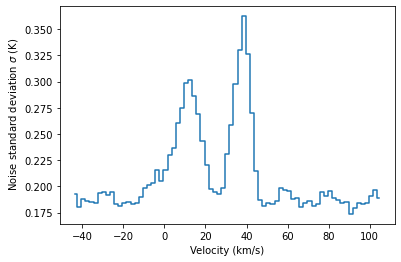

In [32]:
# Make signal mask out of template molecule cube, in noise-free area (should be flat)
cube_sclip = cube1vel_cutout_bgsubtract.sigma_clip_spectrally(3)
mad_std_spectrum_sclip = cube_sclip.mad_std(axis=(1, 2))
plt.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, 
         drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel(r' Noise standard deviation $\sigma$ (K)')
plt.show()

We can see that between -15 and 45 km/s, the noise estimate is affected by signal. However, above 60 km/s, the noise is flatter. We'll use this part of the spectrum to estimate the noise map.

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


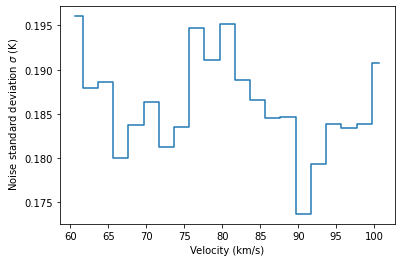

In [33]:
# Calculate noise map based on flat part of spectrum
cube_sclip_cut = cube_sclip.spectral_slab(60*u.km/u.s, 100*u.km/u.s)
mad_std_spectrum_sclip_cut = cube_sclip_cut.mad_std(axis=(1, 2))
plt.plot(mad_std_spectrum_sclip_cut.spectral_axis.value, mad_std_spectrum_sclip_cut.value, 
         drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel(r' Noise standard deviation $\sigma$ (K)')
mad_std_map_sclip = cube_sclip_cut.mad_std(axis=0) # Calculate sigma along the spectral dimension

Now, we'll create a "plain mask" where we mask the template cube and only keep pixels that are at or above 3 sigma (where sigma is given on a pixel-by-pixel basis by the noise map we just created). This procedure was originally illustrated in this [signal masking tutorial](https://mybinder.org/v2/gh/radio-astro-tools/tutorials/HEAD?filepath=masking_and_moments%2Fmasking_and_moments_guide.ipynb).

In [34]:
# Calculate and apply plain mask
plain_mask = cube1vel_cutout_bgsubtract >= 3 * mad_std_map_sclip # Get plain 3sigma mask
plain_masked_slab = cube1vel_cutout_bgsubtract.with_mask(plain_mask) # Mask the template molecule cube

In [35]:
plain_masked_slab.shape

(75, 250, 250)

Then, we'll apply that mask to the template molecule cube and create a more sophisticated "signal mask" from that cube, which takes into account the fact that connected regions of signal are more likely to be real than an individual high-sigma pixel.

In [36]:
import scipy.ndimage as nd
# Make a low and high mask
low_snr_mask = (plain_masked_slab > 3 * mad_std_map_sclip).include()
high_snr_mask = (plain_masked_slab > 10 * mad_std_map_sclip).include()
# low_snr_mask = low_snr_mask.compute() # Don't need this for this tutorial
# high_snr_mask = high_snr_mask.compute() # Don't need this for this tutorial
# Find connected structures
structure = np.ones((3, 3, 3), dtype=bool)
low_snr_mask_labels, num_labels = nd.label(low_snr_mask, structure=structure)
print(f"Initial number of regions found: {num_labels}")
# From the labels, count the number of pixels within each label.
num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                     labels=low_snr_mask_labels,
                                     index=range(1, num_labels + 1)) # +1 offset for mask labels
# Repeat for the high signal mask.
num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                    labels=low_snr_mask_labels,
                                    index=range(1, num_labels + 1)) # +1 offset for mask labels
# To preserve the low_snr_mask, we will create a new signal mask where we will remove 
# regions that do not pass the criteria.
signal_mask = low_snr_mask
low_min_pixels = 40
high_min_pixels = 10
for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, 
                                                      num_pixels_in_low_snr_mask)):
    if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
        # This region passes the criteria. Keep it in the mask.
        continue
    # Remove regions that do not pass the criteria.
    # NOTE: enumerate will start with 0, but the mask labels start at 1
    # We apply a +1 offset to `num` to account for this.
    signal_mask[low_snr_mask_labels == num + 1] = False
signal_mask_labels, num_labels = nd.label(signal_mask,
                                          structure=structure)
print(f"Final number of regions found: {num_labels}")

Initial number of regions found: 11705
Final number of regions found: 7


### Binary dilation

The process of binary dilation grows the mask by one pixel outwards in every direction. This is meant to smooth the rough edges of the mask that may be generated when we perform these cuts, and it could help us to recover real contiguous signal that we may have accidentally removed in the masking process. However, it can also pick up noise. *User beware: compare the number of outliers in your final moment maps (this is done in a future step) with and without binary dilation to determine if you wish to use it in your processing.*

In [37]:
# signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)

### Mask application

Finally, we'll apply the signal mask we just created using the template molecule cube (which has a mask at each velocity step) to the target molecule cube.

In [38]:
# Apply signal mask from template molecule to target molecule
masked_cube = cube2vel_reproj_bgsubtract.with_mask(signal_mask)

# # We can write the masked cube to a file and look at it in DS9, but this is optional:
# masked_cube.write('masked_target_cube.fits', overwrite=True)
# masked_cube = SpectralCube.read('masked_target_cube.fits')

Visualizing the masks:

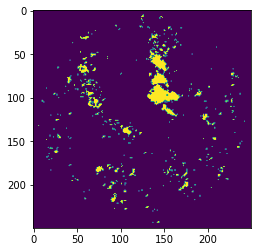

In [39]:
plain_mask_comp = plain_mask.include() # Need to compute this mask before we visualize it
plt.imshow(plain_mask_comp[30]) # Pick a channel
plt.show()

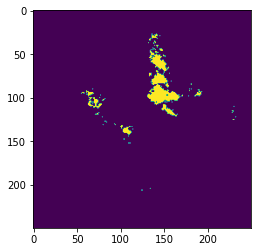

In [40]:
plt.imshow(signal_mask[30]) # Pick that same channel
plt.show()

## Step 7: Moment Maps

First, we'll create some initial moment maps of the target molecule using the cube we just masked. The negative values in these moment maps are due to us using a mask from one cube to mask signal in another cube. We can pick up noise that way, and since the noise can be negative, the sum along the spectral axis (which is what we are plotting in a moment 0 map) can also be negative.

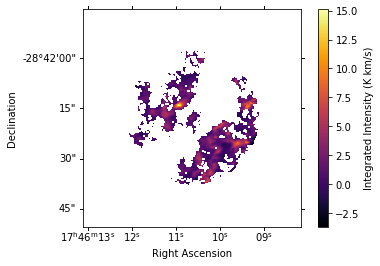

In [41]:
# Make moment maps from the target cube
masked_moment0 = masked_cube.moment0()

ax = plt.subplot(projection = masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')
ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


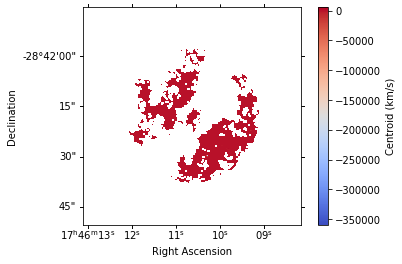

In [42]:
masked_moment1 = masked_cube.moment1()

ax = plt.subplot(projection = masked_moment1.wcs)
im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

The color bar on the moment 1 map is skewed due to the presence of at least one outlier pixel with a large negative velocity.

## Step 8: Masking Outliers

At the moment, to get a better idea of the velocity structure of the target molecule, we can mask the outliers by masking pixels with a moment 0 value less than some threshold, which can cause moment 1 values to blow up since the moment 0 value appears in the denominator of the moment 1 value.

/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


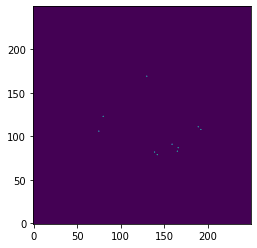

In [43]:
# Look for outliers
v_thresh = 1000
masked_moment1 = masked_cube.moment1()
masked_moment1_outliers = (masked_moment1 > v_thresh*u.km/u.s)|(masked_moment1 < -v_thresh*u.km/u.s)
plt.imshow(masked_moment1_outliers, origin='lower') 
# Clumps of outliers might mean they're real, just outside of vel range
plt.show()

-359493.3414641982 km / s


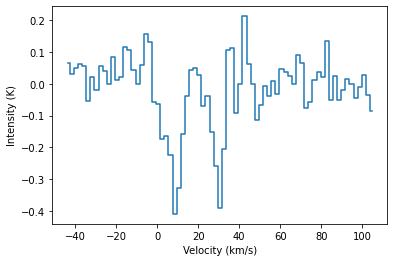

In [44]:
# Look at spectra of outliers individually, can check neighboring spectra here too
max_vel_coord = np.unravel_index(np.nanargmin(masked_moment1), masked_moment1.shape)
spectrum = masked_cube[:, max_vel_coord[0], max_vel_coord[1]]
print(masked_moment1[max_vel_coord[0], max_vel_coord[1]])
plt.plot(spectrum.spectral_axis, spectrum.value, drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Intensity (K)')
plt.show()

In [45]:
# Remove outliers
mom0 = masked_cube.moment0()
mom0_mask = mom0 > 1.*u.K*u.km/u.s # Mask pixels with mom0 less than threshold
print(f"Found {mom0_mask.sum()} good pixels")
masked_cube_no_outliers = masked_cube.with_mask(mom0_mask)

Found 3610 good pixels


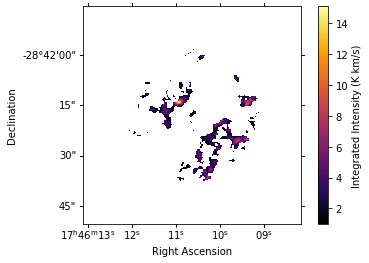

In [46]:
# Make moment maps from the target cube with outliers removed
masked_moment0 = masked_cube_no_outliers.moment0()

ax = plt.subplot(projection = masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')
ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


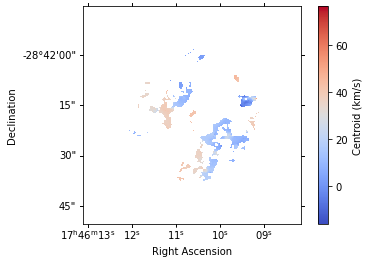

In [47]:
masked_moment1 = masked_cube_no_outliers.moment1()

ax = plt.subplot(projection = masked_moment1.wcs)
im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

The velocity structure is more visible here with the outliers removed.

In [48]:
# masked_moment1.write('moment1.fits')

### Addendum: collapse masked cube along spatial axes to make PV projections

In [49]:
masked_cube_no_outliers.shape # (75, 250, 250)
collapse1 = masked_cube_no_outliers.sum(axis = 1) # Collapse along one spatial axis
collapse2 = masked_cube_no_outliers.sum(axis = 2) # Collapse along the other spatial axis

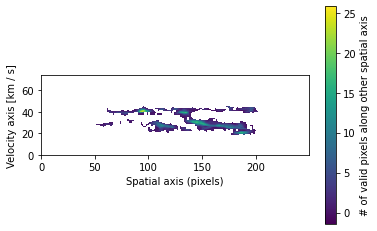

In [50]:
plt.imshow(collapse1.value, origin='lower')
plt.xlabel('Spatial axis (pixels)')
plt.ylabel(f'Velocity axis [{masked_cube_no_outliers.spectral_axis.unit}]')
plt.colorbar(label = '# of valid pixels along other spatial axis')
plt.show()

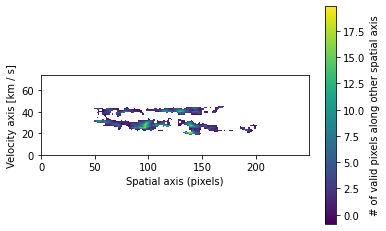

In [51]:
plt.imshow(collapse2.value, origin='lower')
plt.xlabel('Spatial axis (pixels)')
plt.ylabel(f'Velocity axis [{masked_cube_no_outliers.spectral_axis.unit}]')
plt.colorbar(label = '# of valid pixels along other spatial axis')
plt.show()

This is another visualization, but it includes outliers.

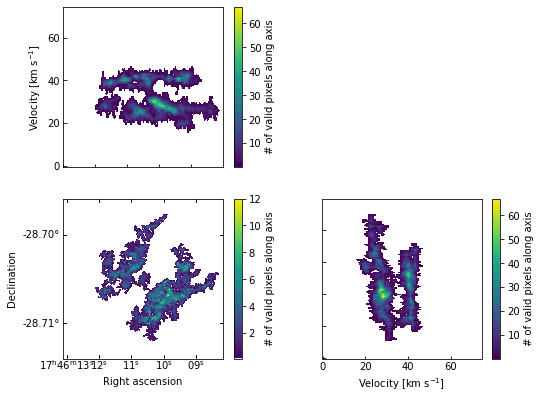

In [52]:
# Imports and matplotlib settings
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.rcParams['figure.facecolor'] = 'w'

# Collapse the mask in three dimensions
mask = signal_mask.sum(axis=0)
collapse1 = signal_mask.sum(axis = 1)
collapse2 = signal_mask.sum(axis = 2)

# Set up maximum value for colorbar
vmax = np.max([mask.max(), collapse1.max(), collapse2.max()])
norm = simple_norm(mask, stretch='linear', max_cut=vmax, min_cut=0.1)
cm = plt.matplotlib.cm.viridis.copy()
cm.set_under('w') # Make sure the "zero" color is white

fig = plt.figure(figsize = (8.5, 10)) # constrained_layout=True

# Get WCS coordinates from an (arbitrary?) masked cube
masked_moment0 = masked_cube.moment0()
wcs = masked_moment0.wcs

# Collapse along axis 0
ax1 = plt.subplot(323, projection = wcs, aspect = 1)
ax1.set_aspect(1)
im1 = ax1.imshow(mask, origin = 'lower', cmap=cm, vmin=0.1)
ax1.tick_params(direction = 'in')
ax1.coords[0].set_major_formatter('hh:mm:ss')
ax1.coords[1].set_major_formatter('d.dd')
ax1.set_xlabel('Right ascension'), ax1.set_ylabel('Declination')
cbar1 = plt.colorbar(mappable = im1, ax = ax1)
cbar1.set_label('# of valid pixels along axis')

# This may not be right:
# overlay = ax1.get_coords_overlay('galactic')
# overlay.grid(color='white', ls='dotted')
# overlay[0].set_axislabel('Galactic longitude')
# overlay[1].set_axislabel('Galactic latitude')

# Collapse along axis 1
ax2 = plt.subplot(321, sharex = ax1) # , adjustable='box'
im2 = ax2.imshow(collapse1, origin = 'lower', norm=norm, cmap=cm)
ax2.xaxis.set_tick_params(labelbottom = False) # Remove redundant tick labels
ax2.tick_params(direction = 'in')
ax2.set_aspect(collapse1.shape[1]/collapse1.shape[0])
ax2.set_ylabel('Velocity [km s$^{{-1}}$]')
cbar2 = plt.colorbar(mappable=im2, ax=ax2)
cbar2.set_label('# of valid pixels along axis')

# Collapse along axis 2
ax3 = plt.subplot(324, sharey = ax1)
im3 = ax3.imshow(collapse2.T, origin = 'lower', norm=norm, cmap=cm)
ax3.yaxis.set_tick_params(labelleft = False) # Remove redundant tick labels
ax3.tick_params(direction = 'in')
ax3.set_aspect(collapse2.shape[0]/collapse2.shape[1])
ax3.set_xlabel('Velocity [km s$^{{-1}}$]')
cbar3 = plt.colorbar(mappable=im3, ax=ax3)
cbar3.set_label('# of valid pixels along axis')

# plt.savefig("figures/mask.pdf", dpi = 300, facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()